---
## Step 0: Load The Data

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import cv2
import os
import random
import numpy as np
import pandas as pd
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle

import time

from numpy import newaxis

import tensorflow as tf
tf.pack = tf.stack
tf.select = tf.where
tf.batch_matmul = tf.matmul

from tensorflow.contrib.layers import flatten

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [8]:
training_file = 'train.p'
validation_file= 'valid.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

n_train = len(X_train)
n_valid = len(X_valid)
n_test = len(X_test)
image_shape = X_train[0].shape
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_valid)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


# ---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

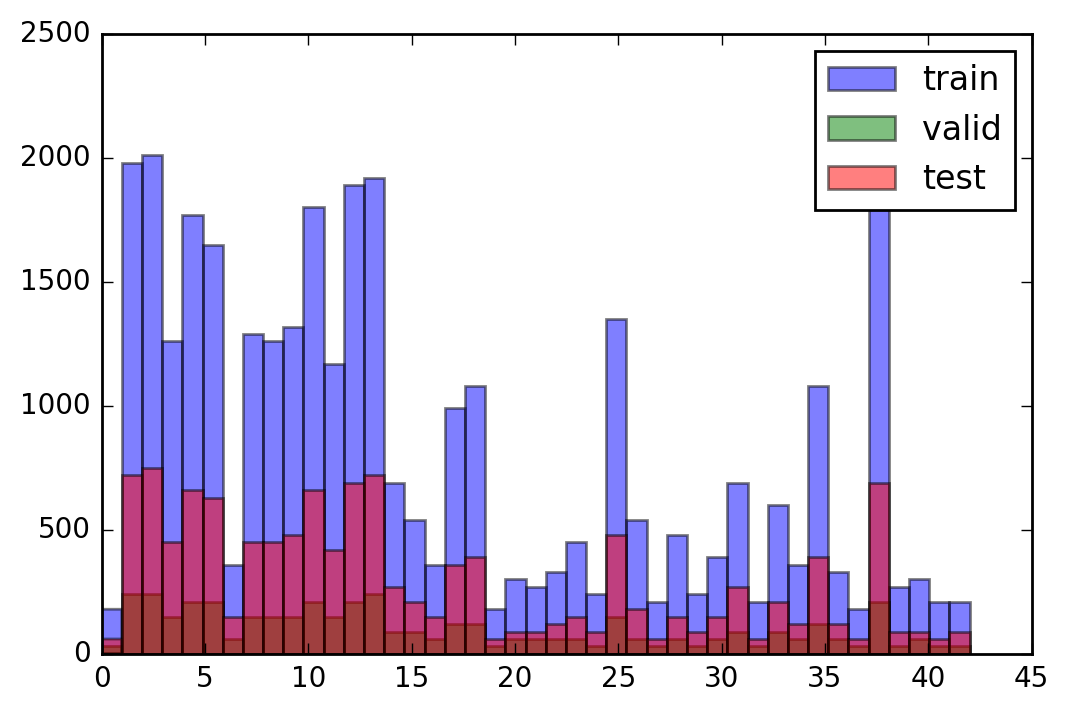

In [3]:
plt.hist(y_train, bins = n_classes, alpha=0.5, label='train')
plt.hist(y_valid, bins = n_classes, alpha=0.5, label='valid')
plt.hist(y_test, bins = n_classes, alpha=0.5, label='test')

plt.legend(loc='upper right')

In [4]:
sign_name_df = pd.read_csv('signnames.csv', index_col='ClassId')
sign_name_df.head()

SignName
ClassId                      
0        Speed limit (20km/h)
1        Speed limit (30km/h)
2        Speed limit (50km/h)
3        Speed limit (60km/h)
4        Speed limit (70km/h)

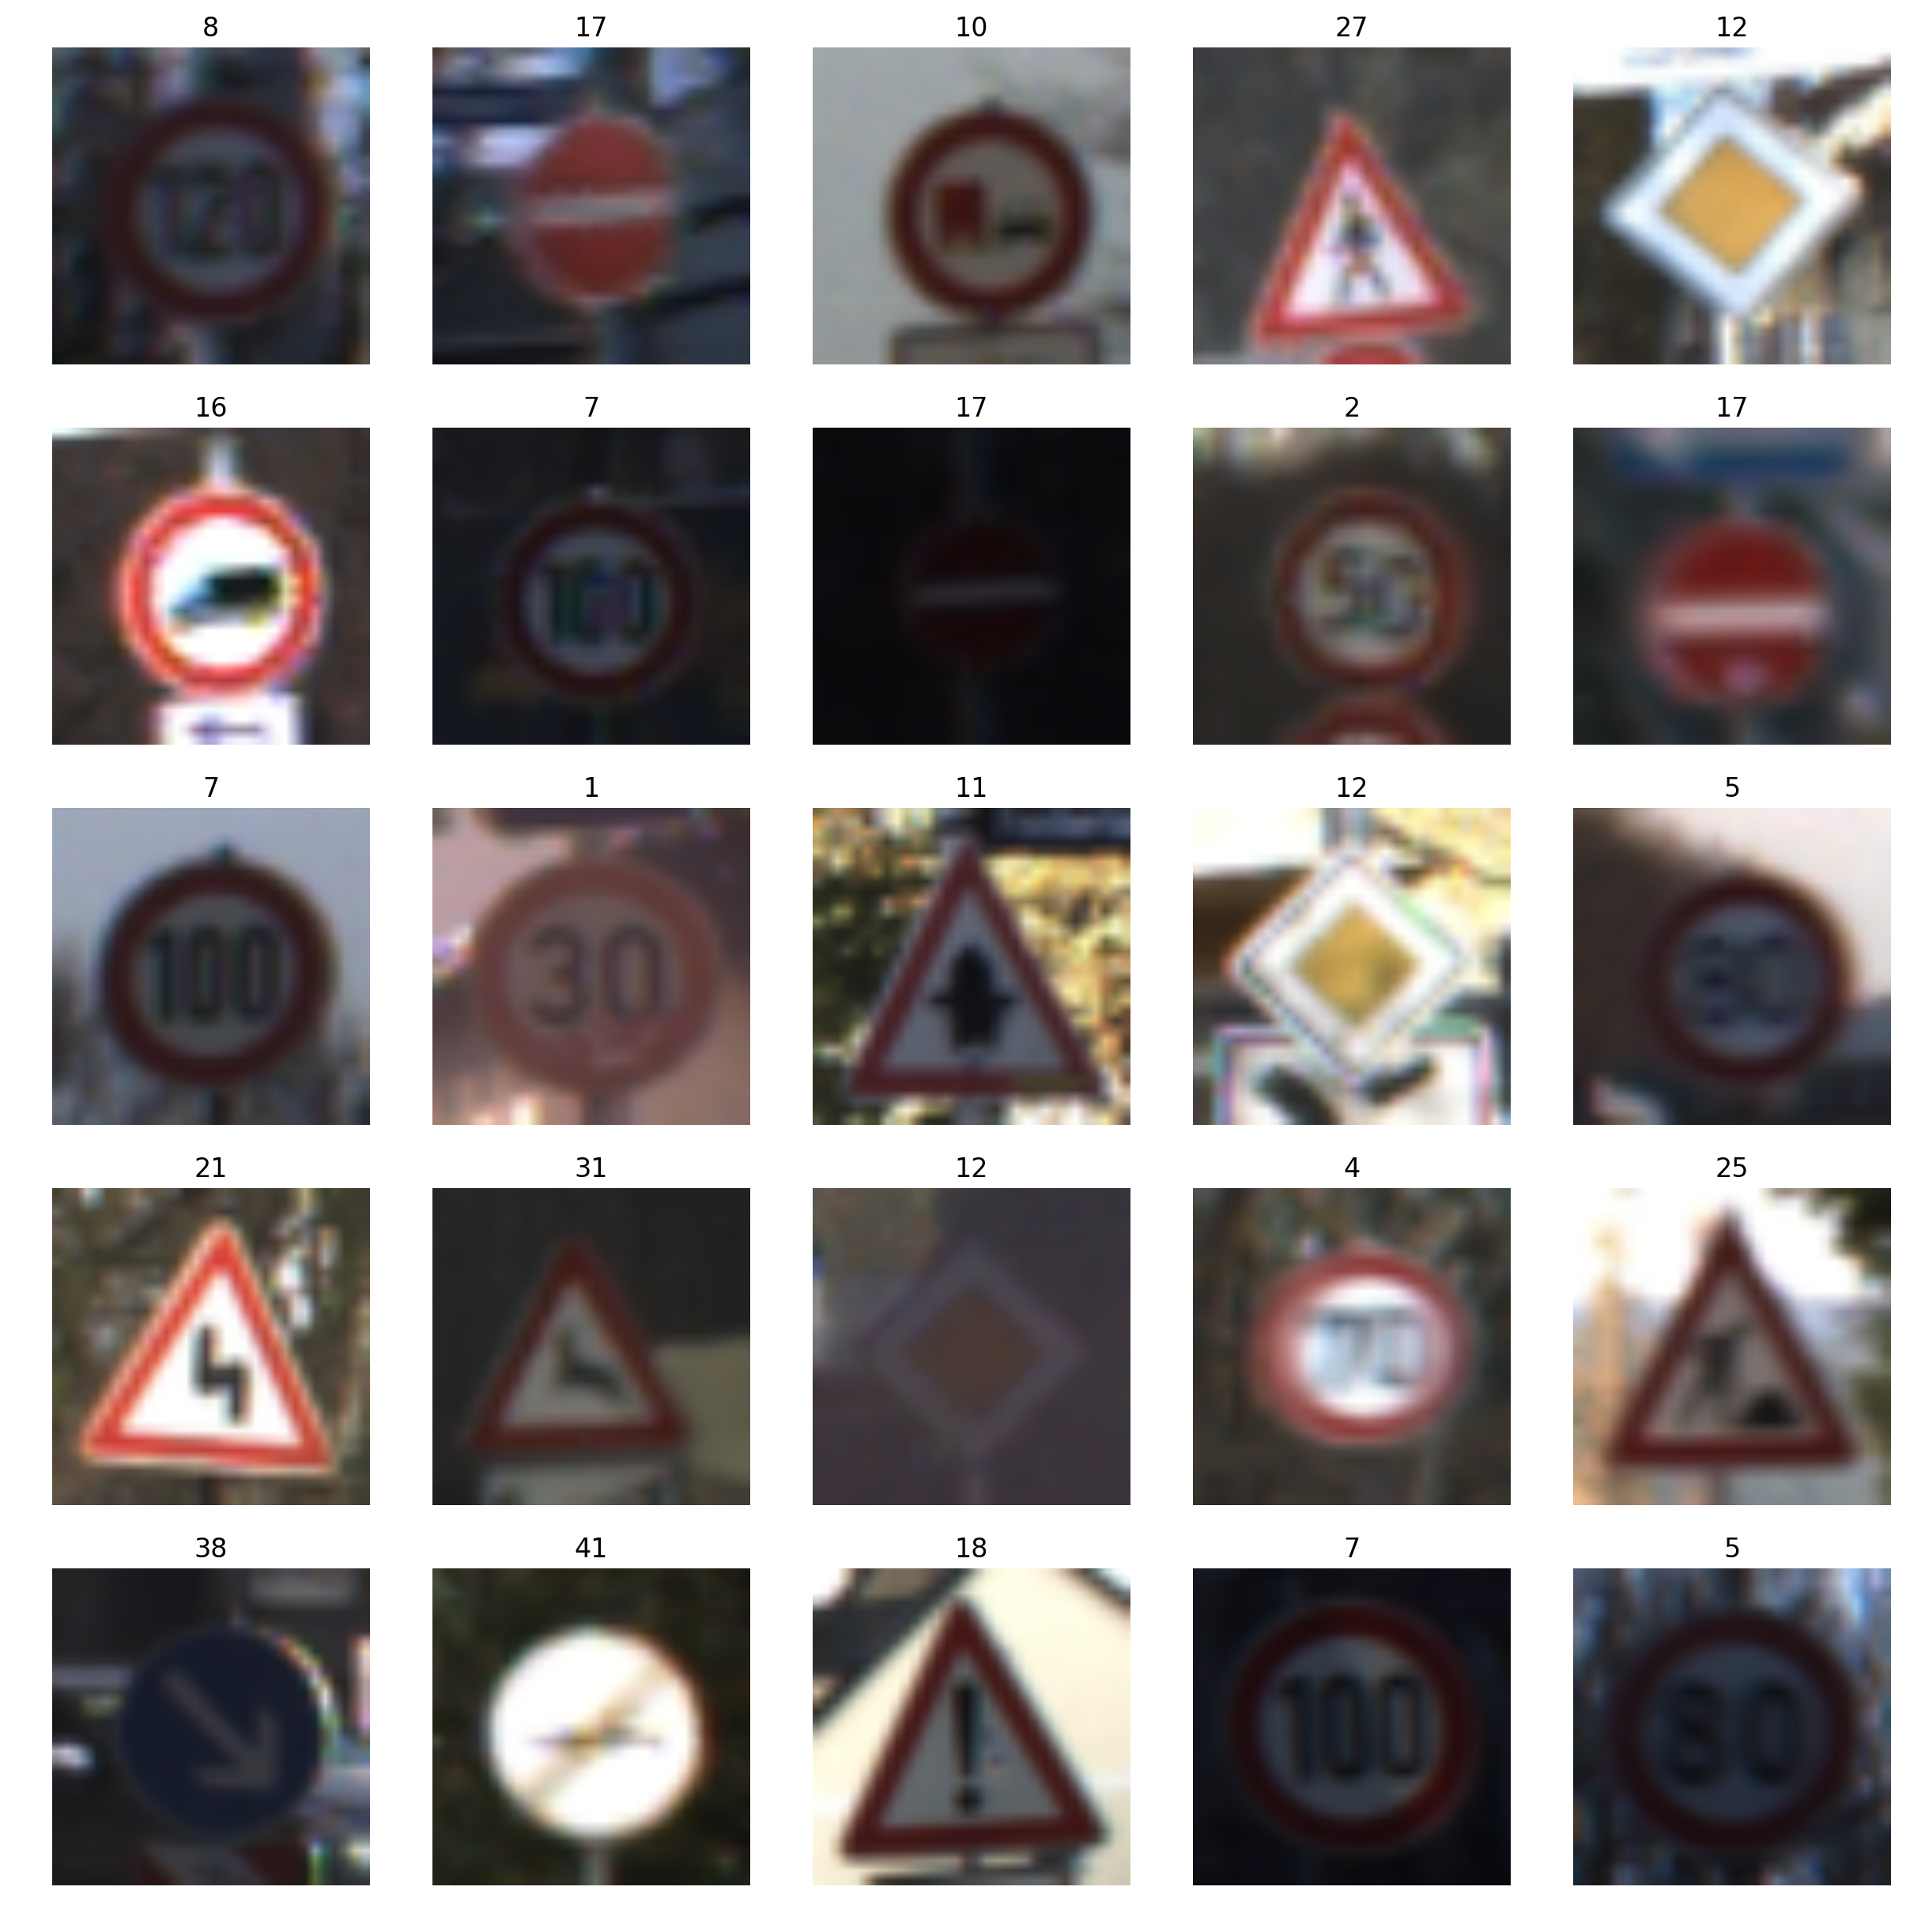

In [4]:
fig, ax = plt.subplots(5,5, figsize=(15, 15), sharex=True)
ax = ax.ravel()
for i in range(25):
    index = random.randint(0, len(X_train))
    image = X_train[index]
    ax[i].axis('off')
    ax[i].imshow(image)
    ax[i].set_title(y_train[index])

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [1]:
def grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

def eqhist(image):
    return cv2.equalizeHist(image)

def normalize(image):
    a = -0.5
    b = 0.5
    min = 0
    max = 255
    return a + ((image - min) * (b - a)) / (max - min)

def preprocess(data):
    processed_images = []
    for image in data:
        processed_image = grayscale(image)
        processed_image = eqhist(processed_image)
        processed_image = normalize(processed_image)
        #processed_image = sharpen_img(processed_image)
        #processed_image = contr_img(processed_image, 0.5)
        processed_images.append(processed_image)
    return np.array(processed_images)

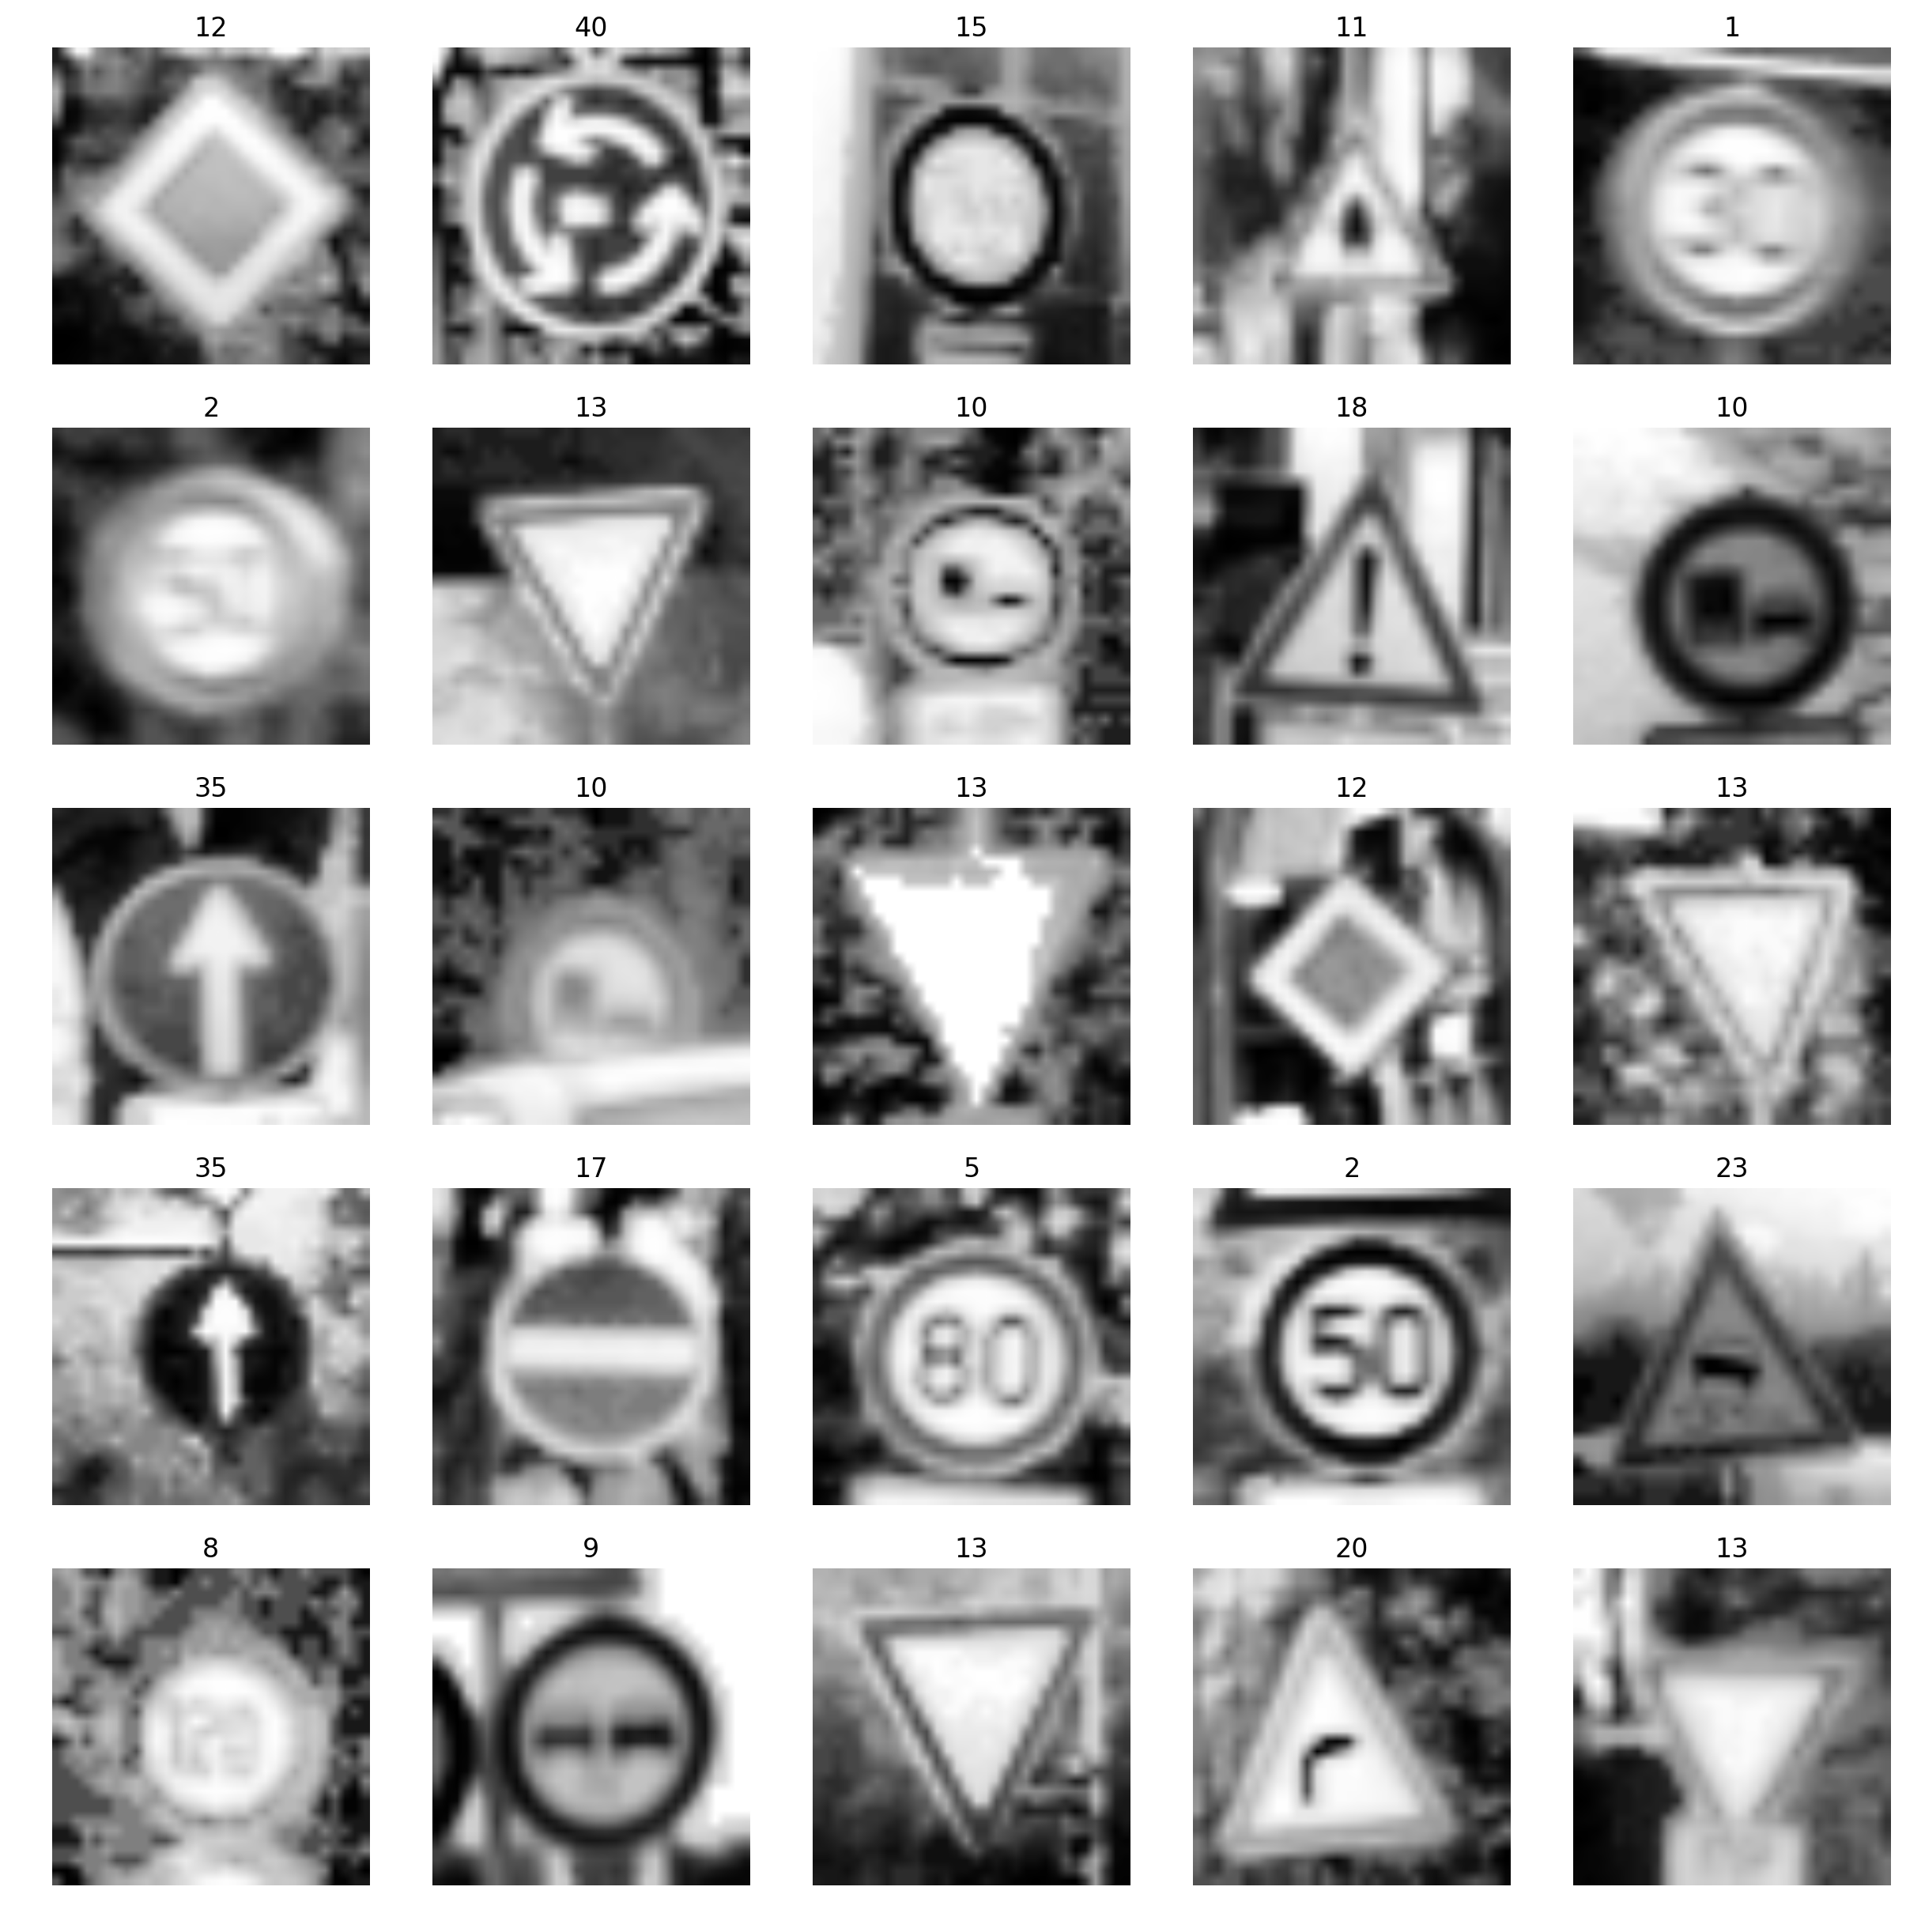

In [9]:
X_train = preprocess(X_train)
X_valid = preprocess(X_valid)
X_test = preprocess(X_test)

fig, ax = plt.subplots(5,5, figsize=(15, 15))
ax = ax.ravel()
for i in range(25):
    index = random.randint(0, len(X_train))
    image = X_train[index]
    ax[i].axis('off')
    ax[i].imshow(image, cmap='gray')
    ax[i].set_title(y_train[index])

In [10]:
X_train = X_train[..., newaxis]
X_valid = X_valid[..., newaxis]
X_test = X_test[..., newaxis]

X_train, y_train = shuffle(X_train, y_train)

print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)


(34799, 32, 32, 1)
(4410, 32, 32, 1)
(12630, 32, 32, 1)


### Model Architecture

In [18]:
EPOCHS = 40
BATCH_SIZE = 100    
    
# Hyperparameters
mu = 0
sigma = 0.1

rate = 0.001

In [19]:
def LeNet(x):
    
    # Convolutional Layer. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros([6]))
    x = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    x = tf.nn.relu(x)

    # Max Pooling. Input = 28x28x6. Output = 14x14x6.
    x = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Convolutional Layer. Output = 10x10x6.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros([16]))
    x = tf.nn.conv2d(x, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    x = tf.nn.relu(x)

    # Max Pooling. Input = 10x10x16. Output = 5x5x16.
    x = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    layer2 = x
    
    # Convolutional Layer. Input = 5x5x16. Output = 1x1x400.
    conv3_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 16, 400), mean = mu, stddev = sigma))
    conv3_b = tf.Variable(tf.zeros([400]))
    x = tf.nn.conv2d(x, conv3_W, strides=[1, 1, 1, 1], padding='VALID') + conv3_b
    x = tf.nn.relu(x)
    
    layer3 = x
    
    # Flatten. Input = 1x1x400. Output = 400.
    layer2_flat = flatten(layer2)
    layer3_flat = flatten(layer3)
    
    x = tf.concat([layer2_flat, layer3_flat], 1)
    print("x shape:", x.get_shape())
    
    x = tf.nn.dropout(x, keep_prob)
    
    # Fully Connected. Input = 800. Output = 43.
    conv4_W = tf.Variable(tf.truncated_normal(shape=(800, n_classes), mean = mu, stddev = sigma))
    conv4_b = tf.Variable(tf.zeros([n_classes]))
    logits = tf.nn.xw_plus_b(x, conv4_W, conv4_b)
    
    return logits

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [13]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)

one_hot_y = tf.one_hot(y, n_classes)

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits = logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

import time
saver = tf.train.Saver()



x shape: (?, 800)


In [20]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print("Training data: ", num_examples)
    print("Classes: ", n_classes)
    
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            loss = sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob : 0.5})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './models/model')
    print("Model saved")

Training...
Training data:  34799
Classes:  43
EPOCH 1 ...
Validation Accuracy = 0.867

EPOCH 2 ...
Validation Accuracy = 0.909

EPOCH 3 ...
Validation Accuracy = 0.926

EPOCH 4 ...
Validation Accuracy = 0.928

EPOCH 5 ...
Validation Accuracy = 0.945

EPOCH 6 ...
Validation Accuracy = 0.941

EPOCH 7 ...
Validation Accuracy = 0.940

EPOCH 8 ...
Validation Accuracy = 0.951

EPOCH 9 ...
Validation Accuracy = 0.952

EPOCH 10 ...
Validation Accuracy = 0.958

EPOCH 11 ...
Validation Accuracy = 0.950

EPOCH 12 ...
Validation Accuracy = 0.951

EPOCH 13 ...
Validation Accuracy = 0.957

EPOCH 14 ...
Validation Accuracy = 0.954

EPOCH 15 ...
Validation Accuracy = 0.961

EPOCH 16 ...
Validation Accuracy = 0.958

EPOCH 17 ...
Validation Accuracy = 0.959

EPOCH 18 ...
Validation Accuracy = 0.958

EPOCH 19 ...
Validation Accuracy = 0.959

EPOCH 20 ...
Validation Accuracy = 0.959

EPOCH 21 ...
Validation Accuracy = 0.959

EPOCH 22 ...
Validation Accuracy = 0.959

EPOCH 23 ...
Validation Accuracy = 0.9

In [21]:
# Launch the model on the test data
with tf.Session() as sess:
    saver.restore(sess, './models/model')

    test_accuracy = sess.run(accuracy_operation, feed_dict={x: X_test, y: y_test, keep_prob : 1.0})

print('Test Accuracy: {}'.format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./models/model
Test Accuracy: 0.9414093494415283


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

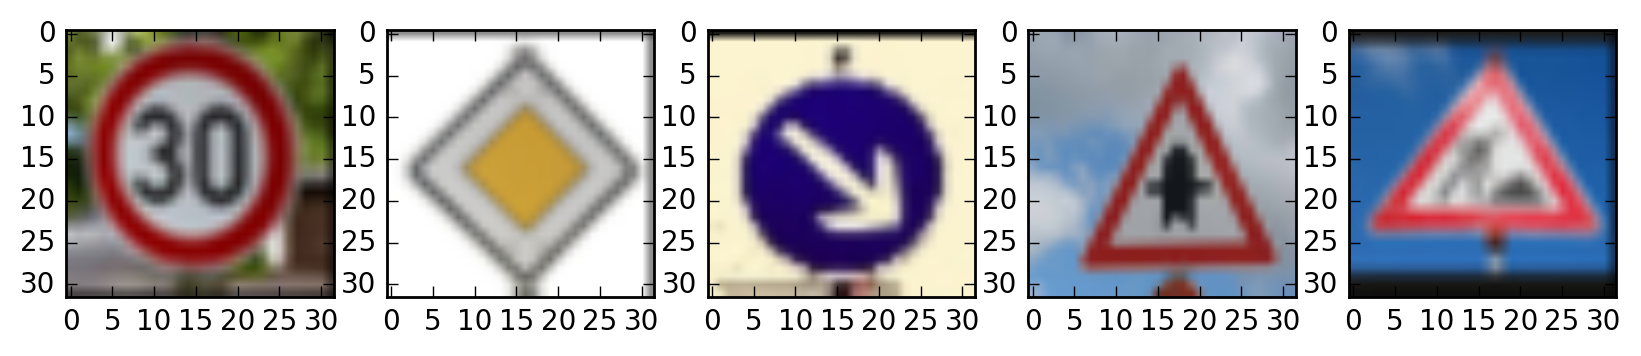

In [71]:
import csv
import glob
sign_names = []
web_images_list = []
        
web_img_paths = [img_path for img_path in glob.glob("./web_traffic_signs/*")]
web_images_list = np.uint8(np.zeros((5,32,32,3)))

for i, img_path in enumerate(web_img_paths):
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (32, 32), interpolation = cv2.INTER_AREA)
    web_images_list[i] = img_resized
    
web_images_list = np.asarray(web_images_list)
    
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(web_images_list[i]) 
plt.show()

Shape before preprocessing (5, 32, 32, 3)


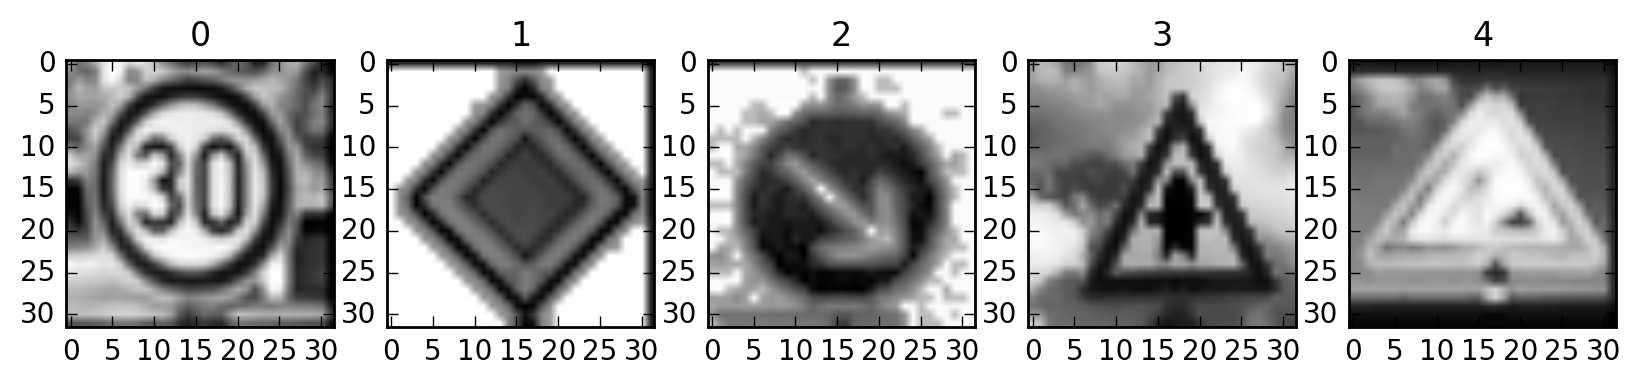

Shape after preprocessing (5, 32, 32, 1)


In [31]:
print("Shape before preprocessing", web_images_list.shape)

processed_samples = preprocess(web_images_list)

plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(processed_samples[i], cmap='gray') 
    plt.title(i)
plt.show()

processed_samples = processed_samples[..., newaxis]

print("Shape after preprocessing", processed_samples.shape)


### Predict the Sign Type for Each Image

In [33]:
sign_names=[]
with open('signnames.csv', 'rt') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=',')
    for row in reader:
        sign_names.append((row['SignName']))

INFO:tensorflow:Restoring parameters from ./models/model
1
12
38
11
20


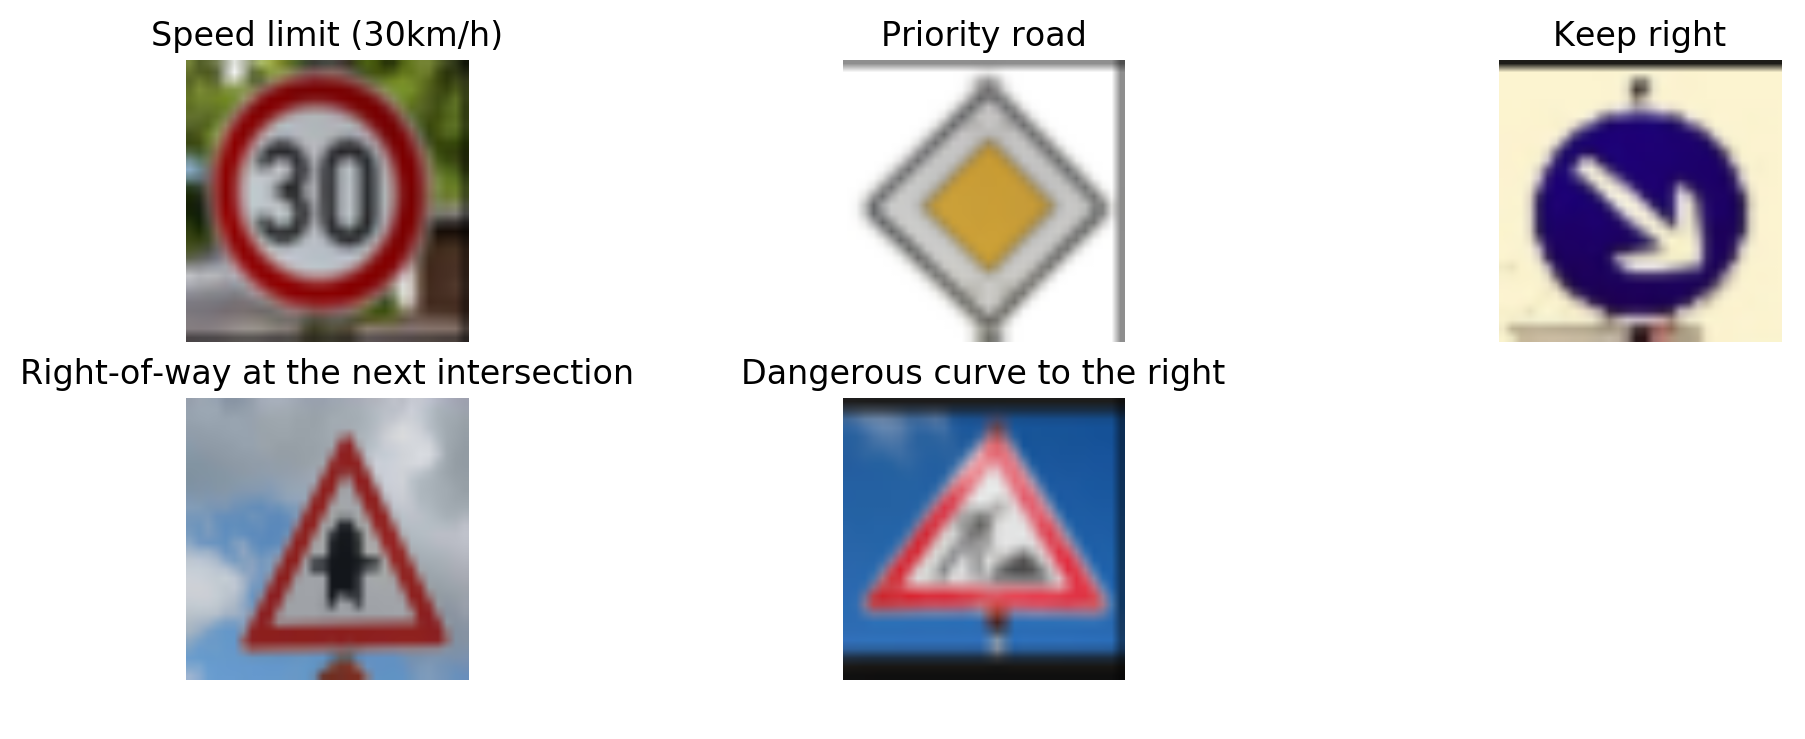

In [34]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

def test_net(X_data, sess):
    pred_sign = sess.run(tf.argmax(logits, 1), feed_dict={x: X_data, keep_prob: 1.0})
    return pred_sign

with tf.Session() as sess:
    saver.restore(sess, './models/model')
    sign_labels = test_net(processed_samples, sess)
    
plt.figure(figsize=(12, 4))
for i in range(5):
    plt.subplot(2, 3, i+1)
    plt.imshow(web_images_list[i]) 
    print(sign_labels[i])
    plt.title(sign_names[sign_labels[i]])
    plt.axis('off')
plt.show()

### Analyze Performance

In [26]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, './models/model')

    test_accuracy = evaluate(processed_samples, sign_labels)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./models/model
Test Accuracy = 1.000


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [44]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

with tf.Session() as sess:
    saver.restore(sess, './models/model')
    softmax_classes = sess.run(tf.nn.softmax(logits), feed_dict={x: processed_samples, keep_prob : 1.0})
    predictions = sess.run(tf.nn.top_k(softmax_classes, k=5, sorted=True))

INFO:tensorflow:Restoring parameters from ./models/model


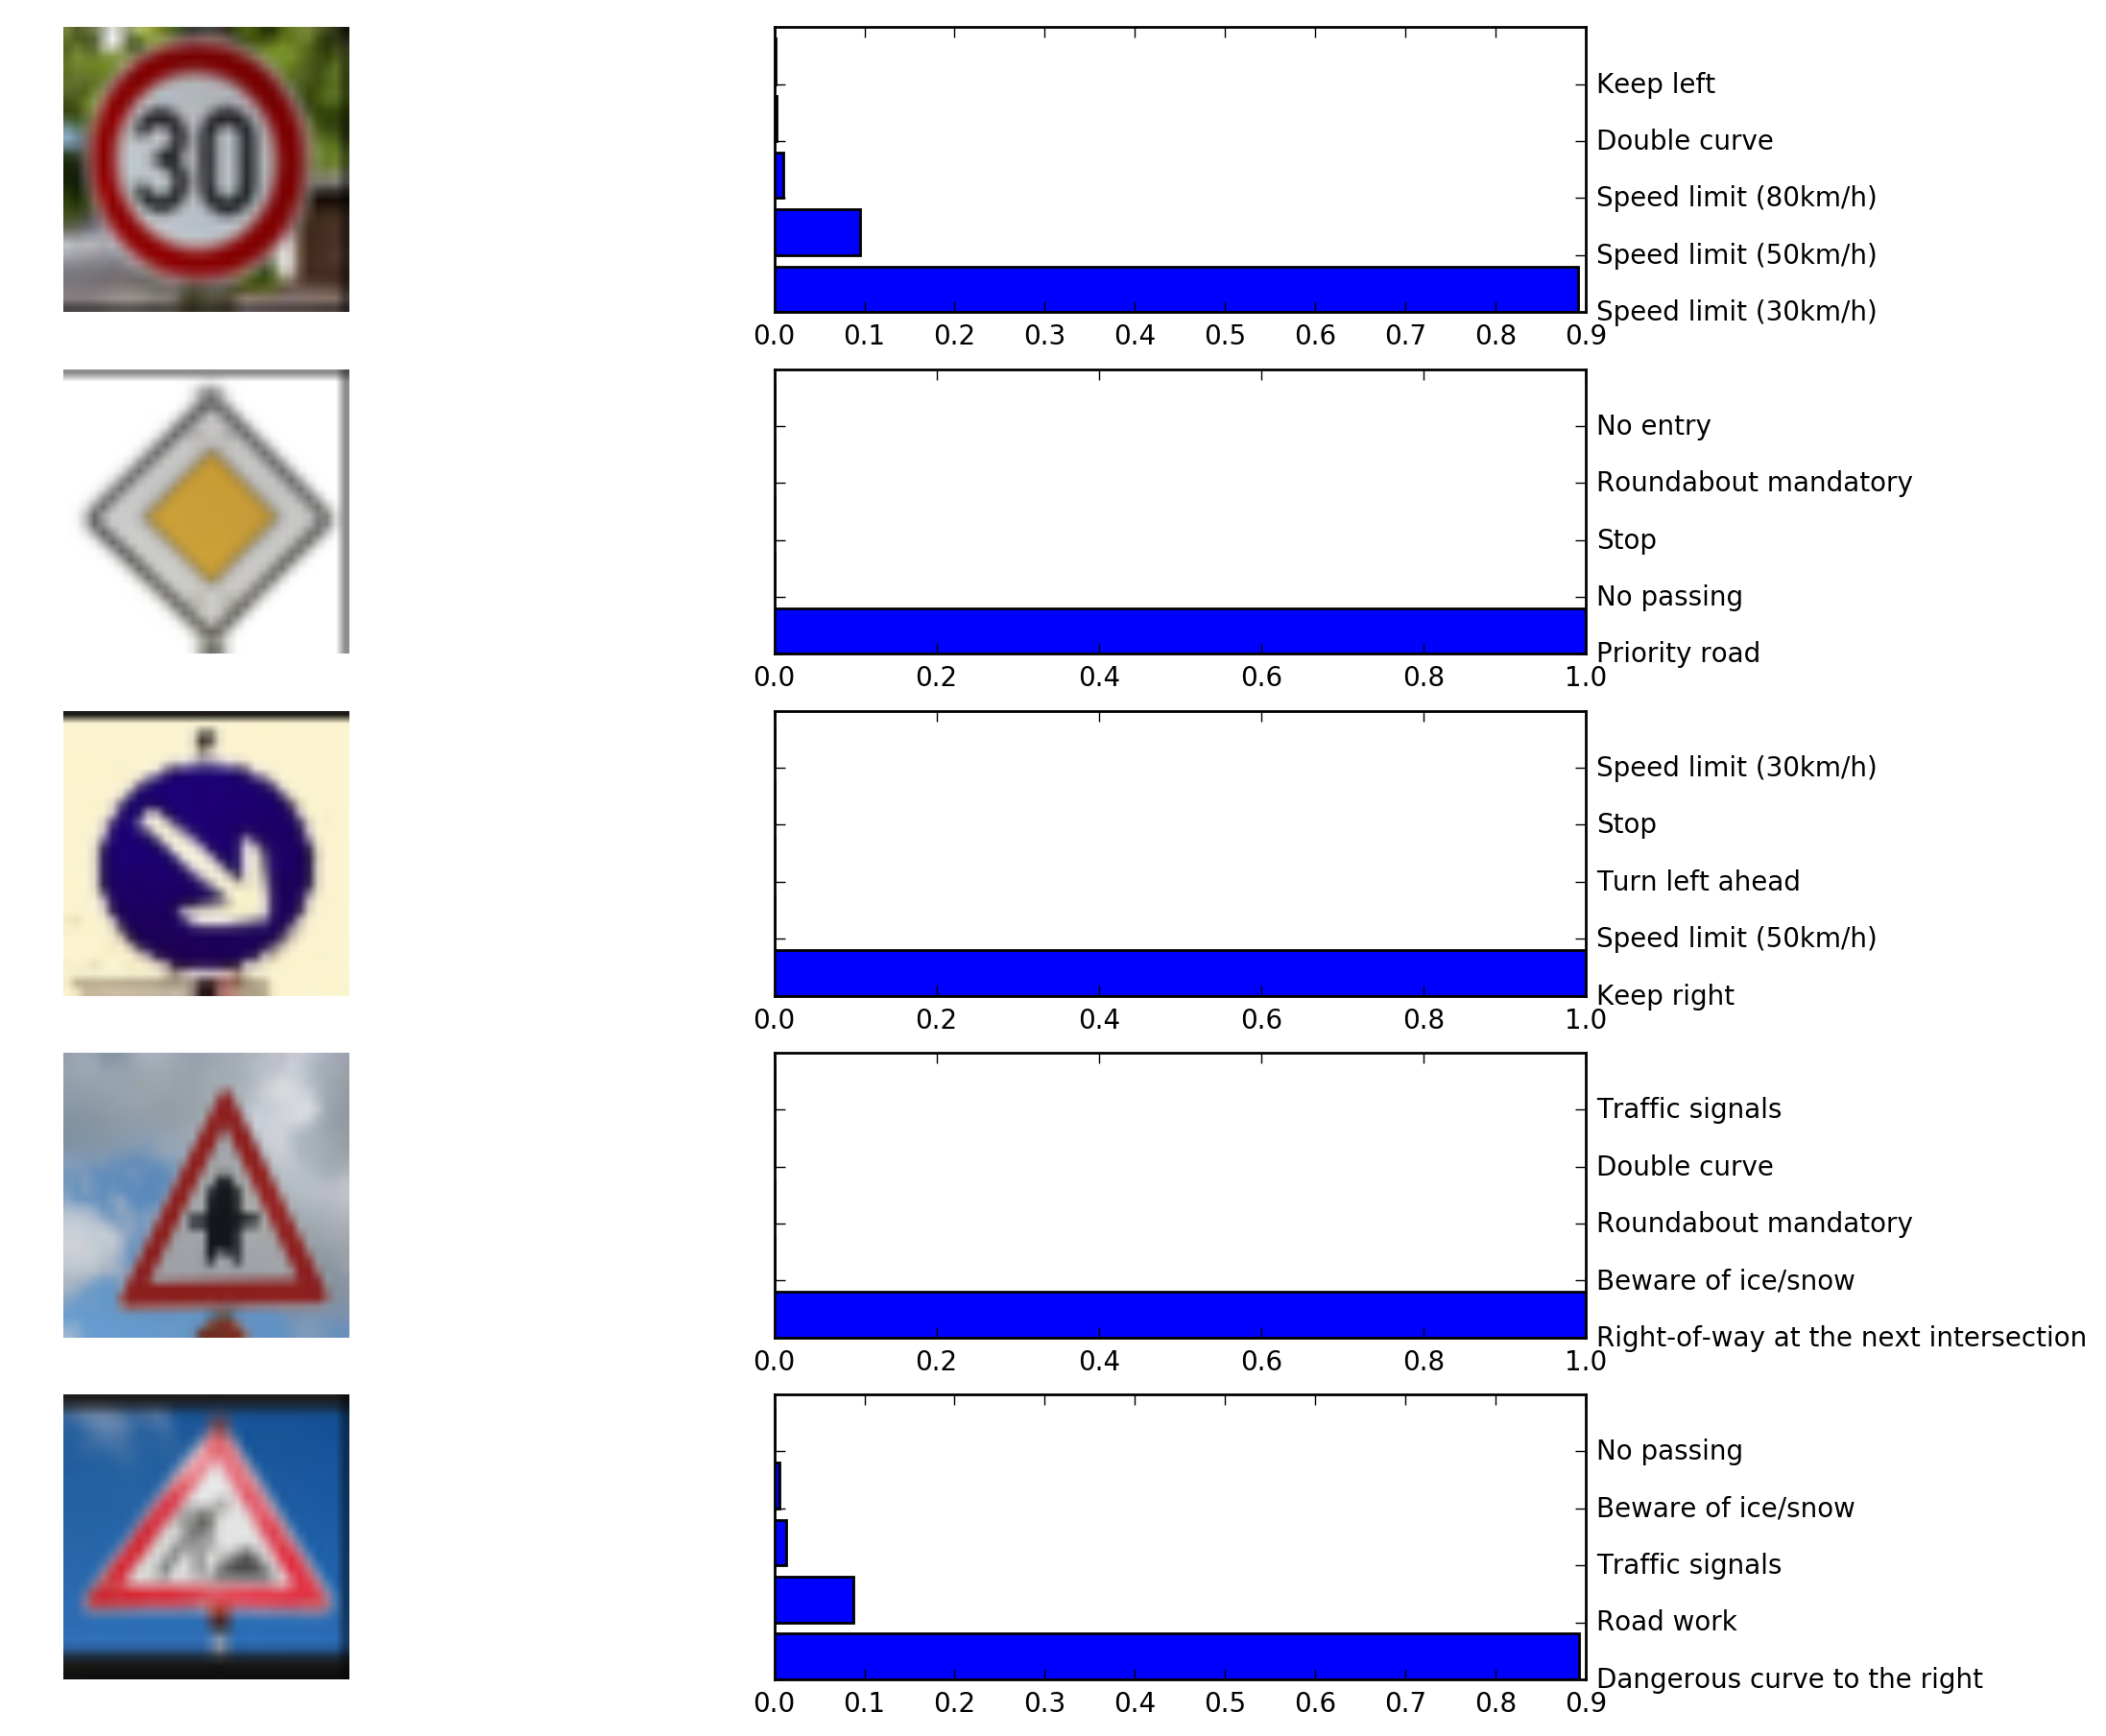

In [70]:
plt.figure(figsize=(12, 18))
for i in range(5):
    plt.subplot(8, 2, 2*i+1)
    plt.imshow(web_images_list[i])
    plt.axis('off')
    plt.subplot(8, 2, 2*i+2)
    plt.barh(np.arange(1, 6, 1), predictions.values[i, :])
    plt.tick_params(labelleft='off' , labelright='on')
    labs=[sign_names[j] for j in predictions.indices[i]]
    plt.yticks(np.arange(1, 6, 1), labs)
plt.show()